# PA3 Part 3. Examining the Activations of a Network [20 Marks]

<center>
    <img src="./assets/huge-nn.jpg">
</center>

### Introduction

In this assignment, you will take a closer look into the activations of a neural network. Building upon the previous task, you will dissect the .

After this notebook you should be able to:

- Understand how to visualize the activations of a neural network.

- Understand how to initialize model parameters better.

- Be a lot more humble about your ability to understand what a neural network is doing.

### Instructions

- Follow along with the notebook, filling out the necessary code where instructed.

- <span style="color: red;">Read the Submission Instructions and Plagiarism Policy in the attached PDF.</span>

- <span style="color: red;">Make sure to run all cells for credit.</span>

- <span style="color: red;">Do not remove any pre-written code.</span> We will be using the `print` statements to grade your assignment.

- <span style="color: red;">You must attempt all parts.</span> Do not assume that because something is for 0 marks, you can leave it - it will definitely be used in later parts.

## Imports

We'll make all our imports here. <span style="color: red;">Do not use any other libraries.</span>

In [2]:
import random

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

## Creating the Dataset (again) [0 Marks]

Since we're going to be diving deeper into the same task as before, we'll just copy the code from the previous notebook.

One small change we'll make is to actually *split* the dataset this time. This will help us see how one small change we'll make, can seriously affect the performance of our model on unseen data.

In [3]:
with open("names.txt") as f:
    words = f.read().splitlines()

# TODO: Build the vocab and the mappings
chars = set(''.join(words)) # set of all characters in the corpus
chars = sorted(list(chars)) # sorted list of all characters

# TODO: Construct the mappings, same as before (don't forget the [.] token)
stoi = dict()
itos = dict()
for i,c in enumerate(chars,1):
    stoi[c] = i
    itos[i] = c

stoi['.'] = 0 # special character for EOS or SOS
itos[0] = '.'

ctx_len = 3

# TODO: Build the dataset in the same fashion as before, given a list of words
def build_dataset(words):
    X, Y = [], []

    for word in words:

        # TODO: Create an vector of zeros of length ctx_len
        ctx = [0]*ctx_len
        
        word = word + '.' # add a . at the end of the word
        
        # Loop through each character in the word
        for char in word:

            # TODO: Convert the character to an index
            char_idx = stoi[char]

            # TODO: Append the context and the index to the X and Y lists respectively
            X.append(ctx)
            Y.append(char_idx)

            # TODO: Update the context by removing the first character and adding the current character
            ctx = ctx[1:]+[char_idx]
    # Convert to tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

# Create the splits
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print(Xtr.shape, Ytr.shape) # (182625,3), (182625)
print(len(Xtr), len(Xva), len(Xte)) # (182625, 22655, 22866)

torch.Size([182625, 3]) torch.Size([182625])
182625 22655 22866


## Breaking down the Model [10 Marks]

Now we can start with a fresh model.

To make things more digestable, instead of using `nn.Linear` that does a lot of other things under the hood, we'll use `nn.Parameter` that just creates trainable tensors (this means we're instantiating the weights and biases for each layer ourselves).

Why?

`nn.Linear` abstracts a lot of things away from us, and we want to be able to see what's going on under the hood. We'll be able to see how the weights and biases change as we train the model.

In [4]:
## Create MLPLMv1 (5 marks)
class MLPLMv1(nn.Module):
    def __init__(self, vocab_size=27, emb_dim=2, ctx_len=3):
        super().__init__()

        # TODO: Create an embedding layer (same as before)
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        
        # TODO: Initialize parameters separately using nn.Parameter and torch.randn
        # Note that w1: (emb_dim * ctx_len, 64), b1: (64)
        self.w1 = nn.Parameter(torch.randn(emb_dim*ctx_len, 64))
        self.b1 = nn.Parameter(torch.randn(64))
        self.w2 = nn.Parameter(torch.randn(64, vocab_size))
        self.b2 = nn.Parameter(torch.randn(vocab_size))

    
    def forward(self, x):

        # TODO: Pass x through the embedding layer and flatten it
        x = self.embedding(x)
        x = x.view(x.size(0), -1)

        # x: (batch_size, emb_dim * ctx_len)
        # TODO: Perform the forward pass in steps using matrix multiplication
        # For the non-linearity, use torch.tanh
        x = torch.tanh(x @ self.w1 + self.b1)
        logits = x @ self.w2 + self.b2
        return logits

# Do a forward pass
model = MLPLMv1()
out = model(Xtr)
print(out.shape) # (dataset size, vocab size)

torch.Size([182625, 27])


Now we will train and evaluate our model (the losses will do for now). 

Be sure to note
- The shape of the loss curves

- The final loss values on both the training and validation sets

- The quality of generated names using the current model

In [5]:
matrix1 = torch.tensor([[1, 2], [3, 4]])
matrix2 = torch.tensor([[5, 6], [7, 8]])
result = matrix1 @ matrix2
print(result)

tensor([[19, 22],
        [43, 50]])


In [6]:
# Training and Evaluation (5 marks)
def fit_one_epoch(model,
                  X, y,
                  optimizer, loss_fn):
    '''
    Perform one epoch of training
    '''
    # Set the model in train mode
    model.train()

    # TODO: Forward Pass (get the logits)
    logits = model(X)

    # TODO: Calculate the loss
    loss = loss_fn(logits, y)

    # TODO: Optimizer zero grad
    optimizer.zero_grad()

    # TODO: Backward pass
    loss.backward()

    # TODO: Step the optimizer
    optimizer.step()

    # Calculate the accuracy
    # Hint: Take the argmax of the logits along the last axis and compare with y
    acc = (logits.argmax(dim=1) == y).float().mean()

    return loss.item(), acc.item()

# TODO: Complete the train_model function (same as before, returning a list of losses)
def train_model(model,
                loss_fn,
                optimizer,
                epochs):
    # Set model to train mode
    model.train()
    
    # Create a list to store the losses
    losses = []

    for epoch in range(epochs):
        logits = model(Xtr)
        loss = loss_fn(logits,Ytr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print(f"Epoch {epoch} | Train loss: {loss:.4f}")

    # Return the losses for plotting later
    return losses

# TODO: Complete the evaluate_model function (returning train and val losses)
@torch.no_grad()
def evaluate_model(model,
                   loss_fn):
    # Set model to eval mode
    model.eval()

    logits_tr = model(Xtr)
    train_l = loss_fn(logits_tr, Ytr).item()

    logits_va = model(Xva)
    val_l = loss_fn(logits_va, Yva).item()

    return train_l, val_l

# Train and evaluate the model (same as before)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


epochs = 700
# Train the model
losses = train_model(model, loss_fn, optimizer, epochs)

# Evaluate the model
train_l, val_l = evaluate_model(model, loss_fn)
print(f"Final Train Loss: {train_l:.2f} | Final Validation Loss: {val_l:.2f}")

Epoch 0 | Train loss: 11.2185
Epoch 1 | Train loss: 10.8524
Epoch 2 | Train loss: 10.5079
Epoch 3 | Train loss: 10.1870
Epoch 4 | Train loss: 9.8904
Epoch 5 | Train loss: 9.6163
Epoch 6 | Train loss: 9.3621
Epoch 7 | Train loss: 9.1256
Epoch 8 | Train loss: 8.9040
Epoch 9 | Train loss: 8.6940
Epoch 10 | Train loss: 8.4914
Epoch 11 | Train loss: 8.2931
Epoch 12 | Train loss: 8.0975
Epoch 13 | Train loss: 7.9044
Epoch 14 | Train loss: 7.7143
Epoch 15 | Train loss: 7.5287
Epoch 16 | Train loss: 7.3487
Epoch 17 | Train loss: 7.1754
Epoch 18 | Train loss: 7.0095
Epoch 19 | Train loss: 6.8513
Epoch 20 | Train loss: 6.7004
Epoch 21 | Train loss: 6.5564
Epoch 22 | Train loss: 6.4187
Epoch 23 | Train loss: 6.2867
Epoch 24 | Train loss: 6.1601
Epoch 25 | Train loss: 6.0386
Epoch 26 | Train loss: 5.9220
Epoch 27 | Train loss: 5.8102
Epoch 28 | Train loss: 5.7032
Epoch 29 | Train loss: 5.6005
Epoch 30 | Train loss: 5.5020
Epoch 31 | Train loss: 5.4073
Epoch 32 | Train loss: 5.3161
Epoch 33 | Train

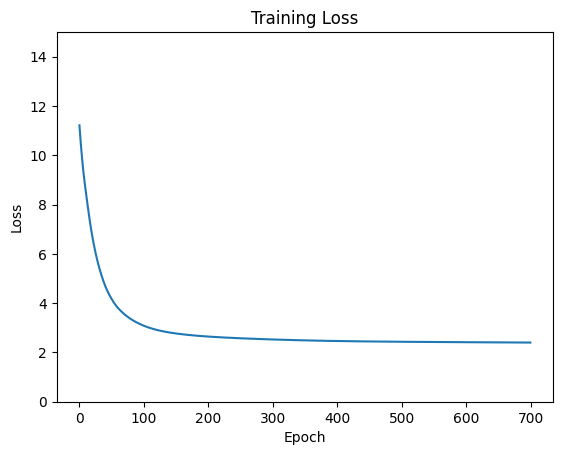

In [7]:
## Plot the losses
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 15)
plt.show()

In [8]:
# TODO: Complete the generate_names function (same as before)
def generate_names(model, num_names=20):
    
    for i in range(num_names):
        ctx = [0]*ctx_len
        gen_name = ''

        # Infinite loop till we get a . character
        while True:

            # TODO: Convert the context to a tensor
            ctx_tensor = torch.tensor(ctx).unsqueeze(0)

            # TODO: Pass the context through the model
            logits = model(ctx_tensor)

            # TODO: Get the probabilities by applying softmax
            probas = F.softmax(logits, dim=1)

            # TODO: Sample from the distribution to get the next character (use torch.multinomial)
            idx = torch.multinomial(probas, 1).item()

            # TODO: Convert the index to a character
            char = itos[idx]

            # Append the character to the generated name
            gen_name += char

            # TODO: Update the context
            ctx = ctx[1:]+[idx]

            # TODO: Break if we get a . character
            if(char=='.'):
                break
        print(gen_name)

generate_names(model, num_names=10)

arley.
ey.
vyre.
than.
erosaltw.
zasion.
quk.
dila.
amdonale.
mibon.


By now, you must have noted

- The sort of *hockey stick* shape of the loss curves, how it has a very steep drop at the beginning, and then slowly flattens out.

- The final loss values on both the training and validation sets are quite high.

- The quality of generated names using the current model is quite poor.

## Fixing the Initial Loss [10 Marks]

The main reason why we used `nn.Parameter` instead of `nn.Linear` is so that we can initialize the weights and biases ourselves. 

Initialization may sound very simple, but a good strategy is difficult to come up with. There's proof that the model you initialized above is starting off on the wrong foot.

If your model was *truly* randomly initialized, it would be predicting tokens with **equal probability**. How do you know it isn't already doing this?

If you initialized the `nn.Parameter` using `torch.randn`, you likely got an initial loss value of close to `13` (we got `13.88` to start with - if you didn't, you might want to revisit your code).

Now suppose your model actually did predict tokens with equal probability. What would the loss be? The cell below will calculate (what *should* be) the starting value of the loss.

In [9]:
vocab_size = len(stoi)

# Generate dummy label: random integer between 0 and vocab_size
dummy_label = torch.randint(low=0, high=vocab_size, size=(1,))

# Generate uniform logits (all logits are equal -> equal probability for all classes)
logits = torch.zeros(vocab_size)

# Using torch.functional.cross_entropy
loss1 = F.cross_entropy(logits.view(1, -1), dummy_label)
print(loss1)

tensor(3.2958)


Putting it in equations, you should be getting a loss of

$$ \text{Loss} = -\frac{1}{N} \sum_{i=1}^{N} \log \frac{1}{V} = \log V $$

where $N$ is the number of tokens in the dataset, and $V$ is the size of the vocabulary. Try this for yourself in your calculator.

What does this tell us?

Our model starts off on the wrong foot: it *should* be making predictions with equal probability, but it isn't; it's actually performing worse than a model that's randomly guessing (which is a *red flag*). This means that the model is already biased towards some tokens, and is predicting them more often than others.

How do we fix this?

There's three techniques for starters:

1. **Zero out the biases**: Does it really make sense to *randomly initialize* the biases? Why should the model be biased towards some tokens more than others? Zeroing out the biases is a good way to start.

2. **Scaling down the weights**: A good portion of training via gradient descent goes into scaling *down* a portion of the weights, to much smaller values. Why not start off with smaller weights to begin with? This would be as simple as multiplying the weights by a small number (say, `0.01`).

3. **Kaiming Initialization**: This is a more advanced technique so we recommend you read about it [here](https://towardsdatascience.com/understand-kaiming-initialization-and-implementation-detail-in-pytorch-f7aa967e9138).
    
    The short of it is that neural networks have an issue with their activations moving further and further away from a normal Gaussian distribution as we go deeper into the network. When the values follow a normal Gaussian distribution, the gradients are more likely to be of similar magnitude, and thus the weights are updated more evenly (which is desirable). Kaiming initialization is a way to reduce the chances of this *shift* happening. You can read the actual paper for this [here](https://arxiv.org/abs/1502.01852), but this is way beyond the scope of this course.

    If you just want the end result, you can look into [this page](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_) from the PyTorch documentation for the equation, and the table at the top of [this page](https://pytorch.org/docs/stable/nn.init.html#torch-nn-init). 
    
    Since we're using a `tanh` activation, we should scale the weights of the first layer by 
    $$\frac{5}{3\sqrt{\text{emb\_dim}\cdot\text{ctx\_len}}}$$

You will now apply these initialization techniques to your model, and see how they affect the loss curves, with the initial and final loss values after training.

<span style="color: red;">Do not change the model architecture, hyperparameters, or the optimizer. We want to see how the initialization affects the model, so keep everything else the same.</span>

In [22]:
import math
class MLPLMv2(nn.Module):
    def __init__(self, vocab_size=27, emb_dim=2, ctx_len=3):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        
        # Initialize parameters separately, now with the three strategies

        # TODO: Apply Kaiming initialization to w1
        kaiming_factor = 5 / (3*math.sqrt(emb_dim*ctx_len))
        self.w1 = nn.Parameter(kaiming_factor * torch.randn(emb_dim*ctx_len, 64))
        # TODO: Zero out the bias
        self.b1 = nn.Parameter(torch.zeros(64))
        # TODO: Scale w2 by 0.01
        self.w2 = nn.Parameter(0.01 * torch.randn(64, vocab_size))
        # TODO: Zero out the bias
        self.b2 = nn.Parameter(torch.zeros(vocab_size))

    def forward(self, x):

        # TODO: Same as before
        x = self.embedding(x)
        x = x.view(x.size(0), -1)

        x = torch.tanh(x @ self.w1 + self.b1)
        x = x @ self.w2 + self.b2

        return x
    

# Train and evaluate the new model

epochs = 700
# Train the model
model2 = MLPLMv2()
out = model(Xtr)
print(out.shape) # (dataset size, vocab size)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.005)
losses = train_model(model, loss_fn, optimizer, epochs)

# Evaluate the model
train_l, val_l = evaluate_model(model, loss_fn)
print(f"Final Train Loss: {train_l:.2f} | Final Validation Loss: {val_l:.2f}")

torch.Size([182625, 27])
Epoch 0 | Train loss: 2.3135
Epoch 1 | Train loss: 2.3135
Epoch 2 | Train loss: 2.3135
Epoch 3 | Train loss: 2.3134
Epoch 4 | Train loss: 2.3134
Epoch 5 | Train loss: 2.3134
Epoch 6 | Train loss: 2.3133
Epoch 7 | Train loss: 2.3133
Epoch 8 | Train loss: 2.3133
Epoch 9 | Train loss: 2.3132
Epoch 10 | Train loss: 2.3132
Epoch 11 | Train loss: 2.3132
Epoch 12 | Train loss: 2.3131
Epoch 13 | Train loss: 2.3131
Epoch 14 | Train loss: 2.3131
Epoch 15 | Train loss: 2.3131
Epoch 16 | Train loss: 2.3130
Epoch 17 | Train loss: 2.3130
Epoch 18 | Train loss: 2.3130
Epoch 19 | Train loss: 2.3129
Epoch 20 | Train loss: 2.3129
Epoch 21 | Train loss: 2.3129
Epoch 22 | Train loss: 2.3128
Epoch 23 | Train loss: 2.3128
Epoch 24 | Train loss: 2.3128
Epoch 25 | Train loss: 2.3127
Epoch 26 | Train loss: 2.3127
Epoch 27 | Train loss: 2.3127
Epoch 28 | Train loss: 2.3126
Epoch 29 | Train loss: 2.3126
Epoch 30 | Train loss: 2.3126
Epoch 31 | Train loss: 2.3125
Epoch 32 | Train loss: 2.

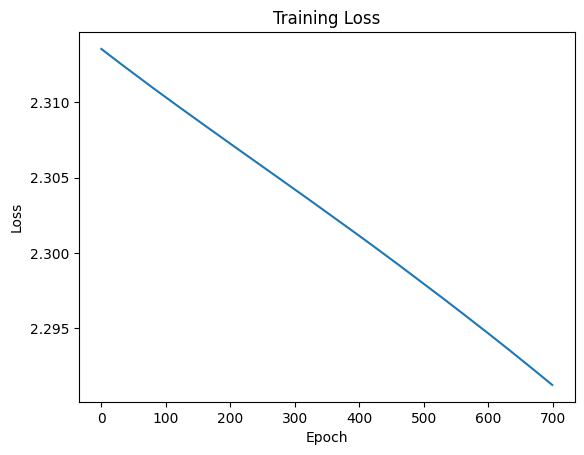

In [36]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.ylim(0, 15)
# plt.ylim(2.3, 2.35)
plt.show()

In [24]:
generate_names(model, num_names=10)

aiann.
prabbiel.
jodlyner.
evan.
masrik.
hylen.
jozarian.
seonne.
sase.
kerrino.


If you've done everything correct so far, you should see

- The initial loss after the initialization should be much closer to the theoretical value we calculated earlier.

- The loss curves should be much smoother, and not have this *hockey stick* shape (that you should realize now was because of the model making redundant corrections to the weights that were fixed by a good initialization).

- The final loss values on both the training and validation sets should be much lower, even though **all we changed** was the initialization scheme.

And you thought you knew all there was to know about neural networks.

## Visualizing the Activations [0 Marks]

If you're still here, we applaud you. In case you want to dissect the model further, continue reading. Otherwise, the assignment is over.

Some claims were made regarding Gaussian distributions and activations and whatnot. Let's see if they're true.

The main idea is that we'd like the distributions of these activations to be as close to a normal Gaussian distribution as possible. This is because the gradients are more likely to be of similar magnitude, and thus the weights are updated more evenly (which is desirable). 

One aspect of this is that the standard deviation of the distribution should be close to `1`. We'll be plotting the the activations of a linear layer, and computing their standard deviation. We find that the Kaiming Initialization scheme will always be better than a random one, since the activations are closer to a normal Gaussian distribution (just note the std for both).

In [25]:
fan_in = 100 # the number of hidden units
kaiming_factor = fan_in ** 0.5 # since we don't have an activation func

Mean of x: -0.0028 | Std of x: 0.9982
Mean of h: 0.0000 | Std of h: 0.9591


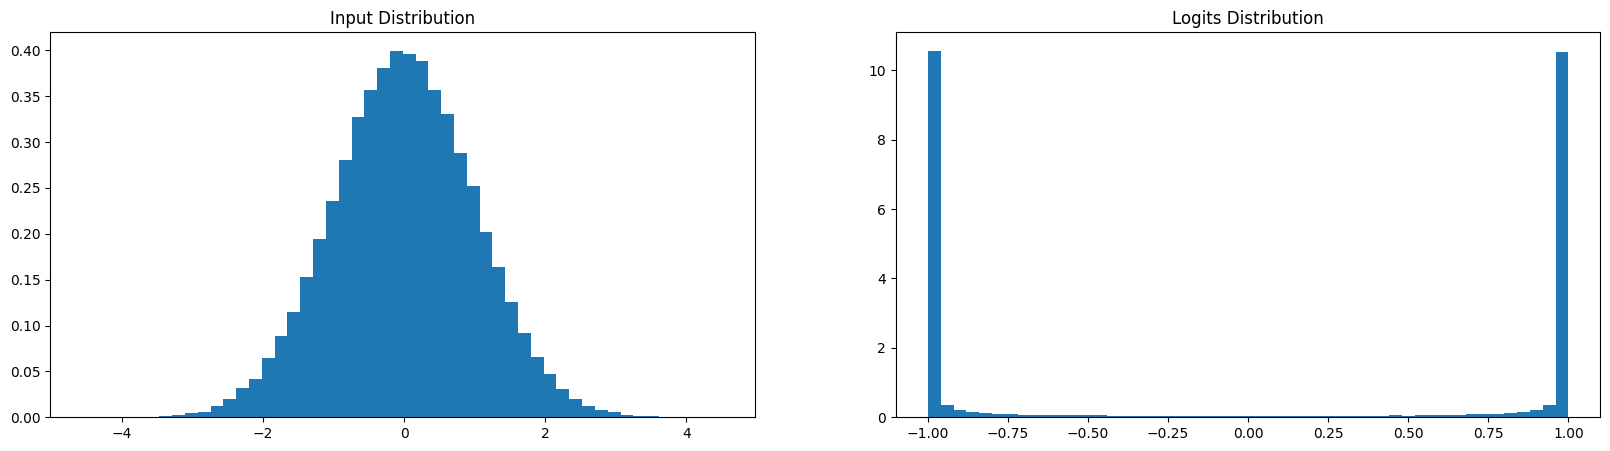

In [26]:
## Distribution WITHOUT Kaiming Initialization
x = torch.randn(1000, fan_in)
w = torch.randn(fan_in, 200)
h = torch.tanh(x @ w)

print(f"Mean of x: {x.mean().item():.4f} | Std of x: {x.std().item():.4f}")
print(f"Mean of h: {h.mean().item():.4f} | Std of h: {h.std().item():.4f}")

# Plot the distributions of input and logits
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('Input Distribution')
plt.hist(x.view(-1).tolist(), 50, density=True, label='x')
plt.subplot(122)
plt.title('Logits Distribution')
plt.hist(h.view(-1).tolist(), 50, density=True, label='y')
plt.show()

Mean of x: -0.0003 | Std of x: 0.9997
Mean of h: -0.0004 | Std of h: 0.9960


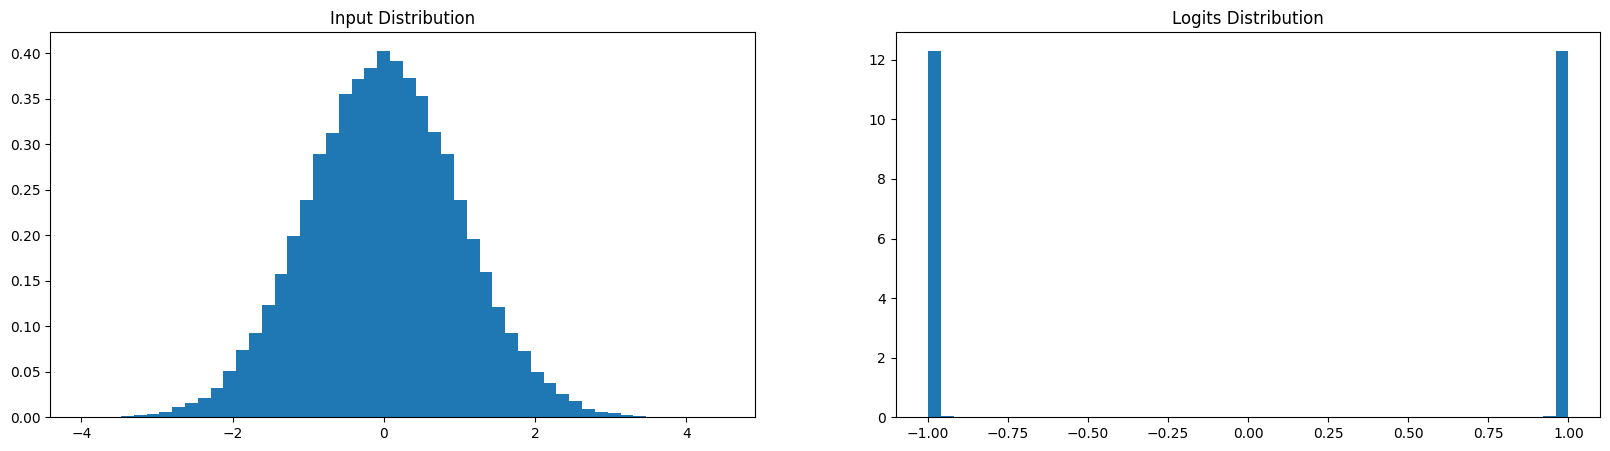

In [27]:
## Distribution WITH Kaiming Initialization
x = torch.randn(1000, fan_in)
w = torch.randn(fan_in, 200) * kaiming_factor
h = torch.tanh(x @ w)

print(f"Mean of x: {x.mean().item():.4f} | Std of x: {x.std().item():.4f}")
print(f"Mean of h: {h.mean().item():.4f} | Std of h: {h.std().item():.4f}")

# Plot the distributions of input and logits
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('Input Distribution')
plt.hist(x.view(-1).tolist(), 50, density=True, label='x')
plt.subplot(122)
plt.title('Logits Distribution')
plt.hist(h.view(-1).tolist(), 50, density=True, label='y')
plt.show()

### With our Trained Model

We'll be using the model we trained earlier, and plotting the activations of the first linear layer. We'll be using the `forward` method of the model to get the activations.

In [28]:
model.eval()

# Get the weights
w1 = model.w1.detach()
b1 = model.b1.detach()
w2 = model.w2.detach()
b2 = model.b2.detach()

# Get the first 1000 examples from the training set and get the activations
Xmb = Xtr[:1000]

with torch.no_grad():
    x = model.embedding(Xmb)
    x = x.view(x.shape[0], -1)
    z = x @ w1 + b1
    h = torch.tanh(z)
    logits = h @ w2 + b2    

Note that the upcoming analysis is based on the `tanh` activation function, and assumes you trained the model correctly in the previous section.

There are three graphs to take note of:

1. The **histogram of the activations** (after `tanh`). Note how the high bars imply the values *saturate* around that point.

2. The **matrix** of locations where the activations (after `tanh`) are *very close* to 1 (also implying saturation).

3. The **histogram of probabilities** - since the model is trained, there should be peaks corresponding to the tokens that are more likely to be predicted (that the model is more confident about).

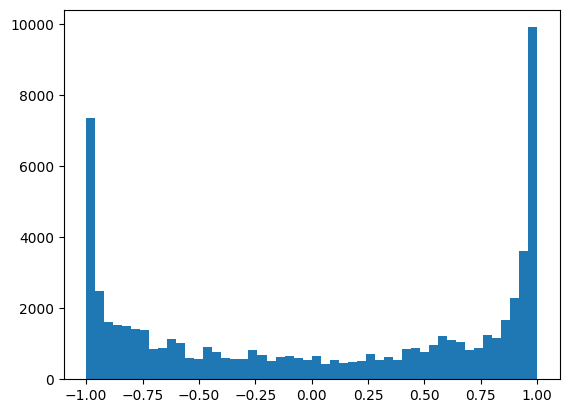

In [29]:
# Plot the distribution of the logits
plt.hist(h.view(-1).tolist(), 50)
plt.show()

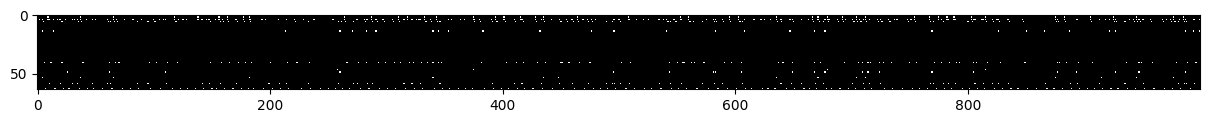

In [30]:
plt.figure(figsize=(15,15))
plt.imshow(h.T.abs() > 0.9999, cmap='gray', interpolation='nearest')
plt.show()

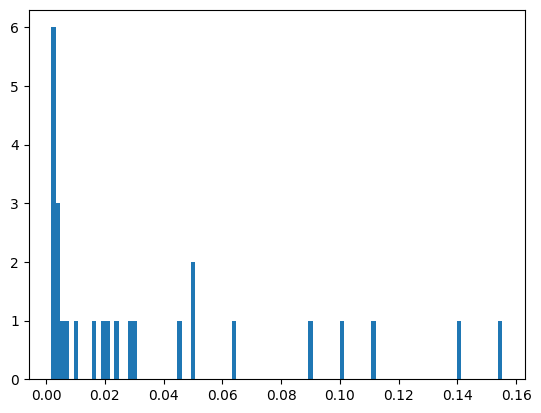

In [31]:
ind = random.choice(range(len(logits)))
probas = F.softmax(logits[ind], dim=0)
plt.hist(probas, bins=100)
plt.show()

### With Poorly Initialized Weights

We can explore the same graphs with the poorly initialized weights. You should see some stark differences.

In [32]:
# Get the weights
w1 = torch.randn(6, 64)
b1 = torch.randn(64)
w2 = torch.randn(64, 27)
b2 = torch.randn(27)

Xmb = Xtr[:1000]

with torch.no_grad():
    x = model.embedding(Xmb)
    x = x.view(x.shape[0], -1)
    z = x @ w1 + b1
    h = torch.tanh(z)
    logits = h @ w2 + b2

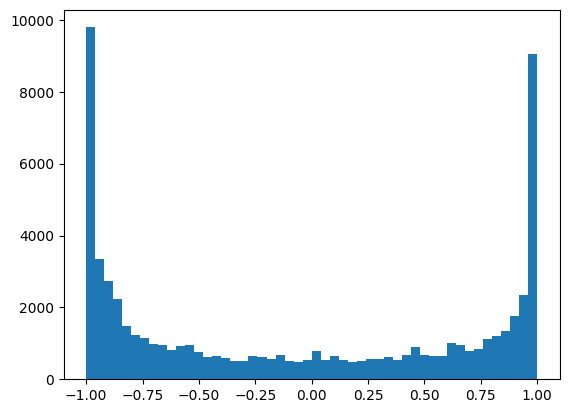

In [33]:
plt.hist(h.view(-1).tolist(), 50)
plt.show()

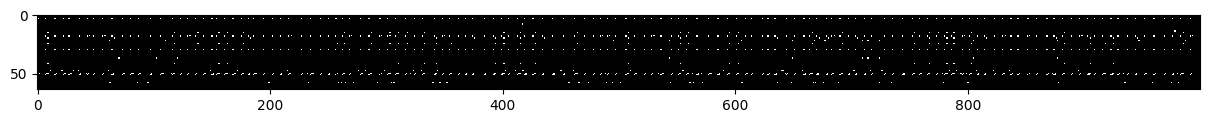

In [34]:
plt.figure(figsize=(15,15))
plt.imshow(h.T.abs() > 0.9999, cmap='gray', interpolation='nearest')
plt.show()

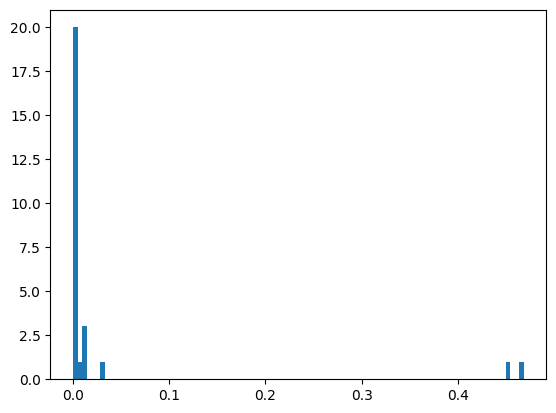

In [35]:
ind = random.choice(range(len(logits)))
probas = F.softmax(logits[ind], dim=0)
plt.hist(probas, bins=100)
plt.show()

Just some food for thought.

## Fin.